# level of analysis : inter subjects (group level)
### this notebook do group level analysis on all clean channels sessions regardless of their p value from decoding results 

In [1]:
import mne
import os 
import numpy as np
import submitit
import pandas as pd 
import math 
import matplotlib.pyplot as plt
from mne.stats import permutation_cluster_test
import h5py


# combine data for each subject

In [4]:

def load_tfr(pid, ch_name, version ):
    """
    Load time-frequency representation (TFR) data using MNE.

    Parameters:
    pid (str): Participant ID.
    ch_name (str): Channel name.

    Returns:
    epochTFR (mne.time_frequency.EpochsTFR or None): The loaded TFR data. Returns None if the file is not found.
    """
    ch_name = ch_name.replace('/', '&')
    tfr_path = os.path.join(base_TF_path, pid, f'powerLF_{version}_{ch_name}.h5')
    if os.path.isfile(tfr_path):
        epochTFR = mne.time_frequency.read_tfrs(tfr_path)
        return epochTFR
    else:
        print(f'TFR file not found for {pid} - {ch_name}')
        return None


def compute_diff_average_tfr(epochTFR, condition1_trial, condition2_trial):
    """
    Compute the difference in average TFR between two conditions.

    Parameters:
    epochTFR (mne.time_frequency.EpochsTFR): The TFR data.
    condition1_trial (list of int): Indices of trials for condition 1.
    condition2_trial (list of int): Indices of trials for condition 2.

    Returns:
    diff_data (numpy.ndarray): The difference in average TFR between the two conditions.
    c1_data (numpy.ndarray): The log-transformed TFR data for condition 1.
    c2_data (numpy.ndarray): The log-transformed TFR data for condition 2.
    """
    c1_data = np.log10(epochTFR.data[condition1_trial].squeeze())
    c2_data = np.log10(epochTFR.data[condition2_trial].squeeze())
    c1_data_av = np.mean(c1_data, axis=0)
    c2_data_av = np.mean(c2_data, axis=0)
    diff_data = c1_data_av - c2_data_av
    return c1_data_av, c2_data_av


def combine_layer(row, version ='raw' ):

    
    pid = row['pid']
    layer_names=['layer1','layer2','layer4','layer5','layer6']

    base_TF_path = '/mnt/data/AdaptiveControl/IBLrawdata/TF_data'
    path_epoch_quality = f'/mnt/data/AdaptiveControl/IBLrawdata/TF_data/{pid}/epoch_quality_{version}.csv'
    power_files = [f for f in os.listdir(os.path.join(base_TF_path, pid)) if f.startswith(f'powerLF_{version}_')]
    quality_data = pd.read_csv(path_epoch_quality)

    bad_trials = quality_data[(quality_data['skewness'] > 1.5) | (quality_data['max_power'] > 500) ]['epoch'].values
    bad_trials = list(set(bad_trials))
    conditions = ['Stim_NoStim', 'Right_Left', 'BiasRight_BiasLeft']
    for condition in conditions:
            
        layer_data1 = {}
        layer_data2 = {}
        for channel_power in power_files:
            
            tfr_path = os.path.join(base_TF_path, pid, channel_power)
            
            epochTFR = mne.time_frequency.read_tfrs(tfr_path)
            ch_name = epochTFR.ch_names[0]    
    
            
            layer_number = int(ch_name[4])  # Extracting the layer number


            meta = epochTFR.metadata.reset_index()

            
            if condition == 'Stim_NoStim':
                condition1_trial = meta.index[(meta['contrastLeft'] == 1) | (meta['contrastRight'] == 1)].tolist()
                condition2_trial = meta.index[(meta['contrastLeft'] < 0.1) | (meta['contrastRight'] < 0.1)].tolist()
            elif condition == 'Right_Left':
                condition1_trial = meta.index[meta['contrastRight'] == 1].tolist()
                condition2_trial = meta.index[meta['contrastLeft'] == 1].tolist()
            elif condition == 'BiasRight_BiasLeft':
                condition1_trial = meta.index[meta['probabilityLeft'] == 0.2].tolist()
                condition2_trial = meta.index[meta['probabilityLeft'] == 0.8].tolist()
            else:
                continue
            
            # Exclude noisy trials
            condition1_trial = [trial for trial in condition1_trial if trial not in bad_trials]
            condition2_trial = [trial for trial in condition2_trial if trial not in bad_trials]
            
            c1_data_av, c2_data_av = compute_diff_average_tfr(epochTFR, condition1_trial, condition2_trial)
            print(f'Computed  average TFR for {pid} - {ch_name} - {condition} 1 and 2')
            
            del epochTFR  # Free up memory
            
            if layer_number not in layer_data1 :
                layer_data1[layer_number] = []
                layer_data2[layer_number] = []
            layer_data1[layer_number].append(c1_data_av)
            layer_data2[layer_number].append(c2_data_av)
            
        layer_objects1 = {}
        for layer_number, data_list in layer_data1.items():
            combined_data = np.stack(data_list)  # Combine data for channels in this layer shape = (n_channels, n_freqs, n_times)
            combined_data = np.mean(combined_data, axis=0, keepdims= True) # Average across channels shape = (1, n_freqs, n_times)
            layer_objects1[layer_number] = combined_data
            print(f'Layer {layer_number} data shape: {combined_data.shape}')
        
        layer_objects2 = {}
        for layer_number, data_list in layer_data2.items():
            combined_data = np.stack(data_list)
            combined_data = np.mean(combined_data, axis=0, keepdims= True)
            layer_objects2[layer_number] = combined_data
            print(f'Layer {layer_number} data shape: {combined_data.shape}')
        
        # save layer_objects
        save_path = os.path.join(base_TF_path, pid, f'TFR_LF_{condition}_all_{version}_all.h5')
        with h5py.File(save_path, 'w') as hf:   
            for layer_name in layer_names:
                layer_number = int(layer_name[-1])  # Extract the layer number from the layer name
                if layer_number in layer_objects1:
                    dataset_name = f'{layer_name}_c1'
                    hf.create_dataset(dataset_name, data=layer_objects1[layer_number])
                if layer_number in layer_objects2:
                    dataset_name = f'{layer_name}_c2'
                    hf.create_dataset(dataset_name, data=layer_objects2[layer_number])
                    
        print(f'Saved combined data for {pid} - {condition} in {save_path}')
                

In [5]:
import os
import pandas as pd
import numpy as np
import mne
from mne.stats import permutation_cluster_test
import h5py
import submitit

base_eid_path = '/mnt/data/AdaptiveControl/IBLrawdata/eid_data'
base_TF_path = '/mnt/data/AdaptiveControl/IBLrawdata/TF_data'
path_summary_data = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data_with_significant_channels.csv'
summary_data = pd.read_csv(path_summary_data)

# summary_data= summary_data[11:12]

executor = submitit.AutoExecutor(folder="logs")

# Define maxjobs to a low value to illustrate
maxjobs = 100

# Pass parameter to the executor
executor.update_parameters(slurm_array_parallelism=maxjobs, mem_gb=16, timeout_min=600, slurm_partition="CPU", cpus_per_task=1)


# Execute the job (note the .map_array command that different from the .submit command used above)
jobs = executor.map_array(combine_layer, [row for _, row in summary_data.iterrows()])


# compute the average over all subjects with permutation results 

In [1]:

def group_level_permutation(condition , layer , version , n_permutations = 600, threshold= None , n_jobs = 5):

    '''
    
    layer should be one of these ['layer1','layer2','layer4','layer5','layer6']
    
    condition should be one of these 'Stim_NoStim','Right_Left','BiasRight_BiasLeft'
    
    '''
    TF_path = '/mnt/data/AdaptiveControl/IBLrawdata/TF_data/'
    group_level_data_path = f'/mnt/data/AdaptiveControl/IBLrawdata/group_level_data/{layer}'
    os.makedirs(group_level_data_path, exist_ok=True)
    X1=[]
    X2 = []
    file_name = f'TFR_LF_{condition}_all_{version}_all.h5'
    no_combine_file_pid = [] # list of pid that do not have the combine file
    dataset_name1 = f'{layer}_c1'
    dataset_name2 = f'{layer}_c2'
    total_subject = 0
    for pid in os.listdir(TF_path):
        
        if os.path.isfile(os.path.join(TF_path, pid, file_name)):
            
            with h5py.File(os.path.join(TF_path, pid, file_name), 'r') as hf:
                try:
                    x1 = hf[dataset_name1][:] #x shape = (1, n_freqs, n_times)
                    x2 = hf[dataset_name2][:] #x shape = (1, n_freqs, n_times)
                    X1.append(x1)
                    X2.append(x2)
                    total_subject += 1
                except:
                    print(f'no data for {pid} in {layer}')
                    continue
        else:
            no_combine_file_pid.append(pid)
    
    X1stack = np.vstack(X1) # X1stack shape = (n_subjects, n_freqs, n_times) for condition one for example stim trials
    X2stack = np.vstack(X2) # X2stack shape = (n_subjects, n_freqs, n_times) for condition two for example no stim trials
    
    
    print(f'shape of X1stack: {X1stack.shape}')
    print(f'shape of X2stack: {X2stack.shape}')
    diff_tfr = X2stack - X1stack # shape = (n_subjects, n_freqs, n_times)
    diff_tfr_averege = np.mean(diff_tfr, axis = 0) # shape = (n_freqs, n_times)
    X = [X2stack, X1stack]
    
    
    
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(X, out_type='mask', n_permutations= n_permutations, threshold=threshold, tail=0, n_jobs= n_jobs)
    print(f'Permutation test completed for {layer} - {condition}')
    
    save_path = os.path.join(group_level_data_path,  f'TFRpermut_LF_{condition}_{version}_all.h5')
    with h5py.File(save_path, 'w') as hf:
        dset = hf.create_dataset('all_subjects_averageTFR', data=diff_tfr_averege)
        dset.attrs['description'] = f'average Difference data for the layer {layer} accross all subjects for {condition} condition. the channels included in this analysis where the one that showed significant p value in decoding result of this conditoin'

        dset = hf.create_dataset('T_obs', data=T_obs)
        dset.attrs['description'] = 'Observed test statistic'

        dset = hf.create_dataset('clusters', data=np.array([c.astype(int) for c in clusters]))
        dset.attrs['description'] = 'Clusters identified in the permutation test'

        dset = hf.create_dataset('cluster_p_values', data=cluster_p_values)
        dset.attrs['description'] = 'P-values for each cluster'

        dset = hf.create_dataset('H0', data=H0)
        dset.attrs['description'] = 'Distribution of the test statistic under the null hypothesis'

        dset = hf.create_dataset('condition', data=np.string_(condition))
        dset.attrs['description'] = 'Condition for the permutation test'


        dset = hf.create_dataset('n_permutations', data=n_permutations)
        dset.attrs['description'] = 'Number of permutations'

        dset = hf.create_dataset('threshold', data=threshold if threshold is not None else np.nan)
        dset.attrs['description'] = 'Threshold for the permutation test'

        dset = hf.create_dataset('number_of_subject', data=total_subject)
        dset.attrs['description'] = 'Number of subjects  included in the analysis'

        dset = hf.create_dataset('version', data=np.string_(version))
        dset.attrs['description'] = 'Version of the data'
            
            
    print(f'Saved permutation results for {layer} - {condition}')
    
       
    if len(no_combine_file_pid) > 0:
        print('WARNING: No combine file for the following pids:')
        print(no_combine_file_pid)
        print('###########################')
    
                
                
                
    
     

In [2]:
import os
import pandas as pd
import numpy as np
import mne
from mne.stats import permutation_cluster_test
import h5py
import submitit
version = 'raw'

for layer in ['layer1','layer2','layer4','layer5','layer6']:
    for condition in ['Stim_NoStim','Right_Left','BiasRight_BiasLeft']:
        executor = submitit.AutoExecutor(folder=os.getcwd()+'/logs/')
        executor.update_parameters(mem_gb=20, timeout_min=400, slurm_partition="CPU", cpus_per_task=5, slurm_comment='group_level_permutation')
        job = executor.submit(group_level_permutation, condition, layer, version)
        

In [12]:
version = 'csd'

for layer in ['layer1','layer2','layer4','layer5','layer6']:
    for condition in ['Stim_NoStim','Right_Left','BiasRight_BiasLeft']:
        executor = submitit.AutoExecutor(folder=os.getcwd()+'/logs/')
        executor.update_parameters(mem_gb=20, timeout_min=400, slurm_partition="CPU", cpus_per_task=5, slurm_comment='group_level_permutation')
        job = executor.submit(group_level_permutation, condition, layer, version)

# plot the results

Reading /mnt/data/AdaptiveControl/IBLrawdata/TF_data/22609d51-0a6a-425d-a3ef-eeb43a9ba350/powerLF_raw_VISp6a_381.h5 ...


/tmp/ipykernel_1826230/3876227940.py:35: RuntimeWarning: This filename (/mnt/data/AdaptiveControl/IBLrawdata/TF_data/22609d51-0a6a-425d-a3ef-eeb43a9ba350/powerLF_raw_VISp6a_381.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  randomTFR = mne.time_frequency.read_tfrs(randomTFRpath)


Replacing existing metadata with 18 columns


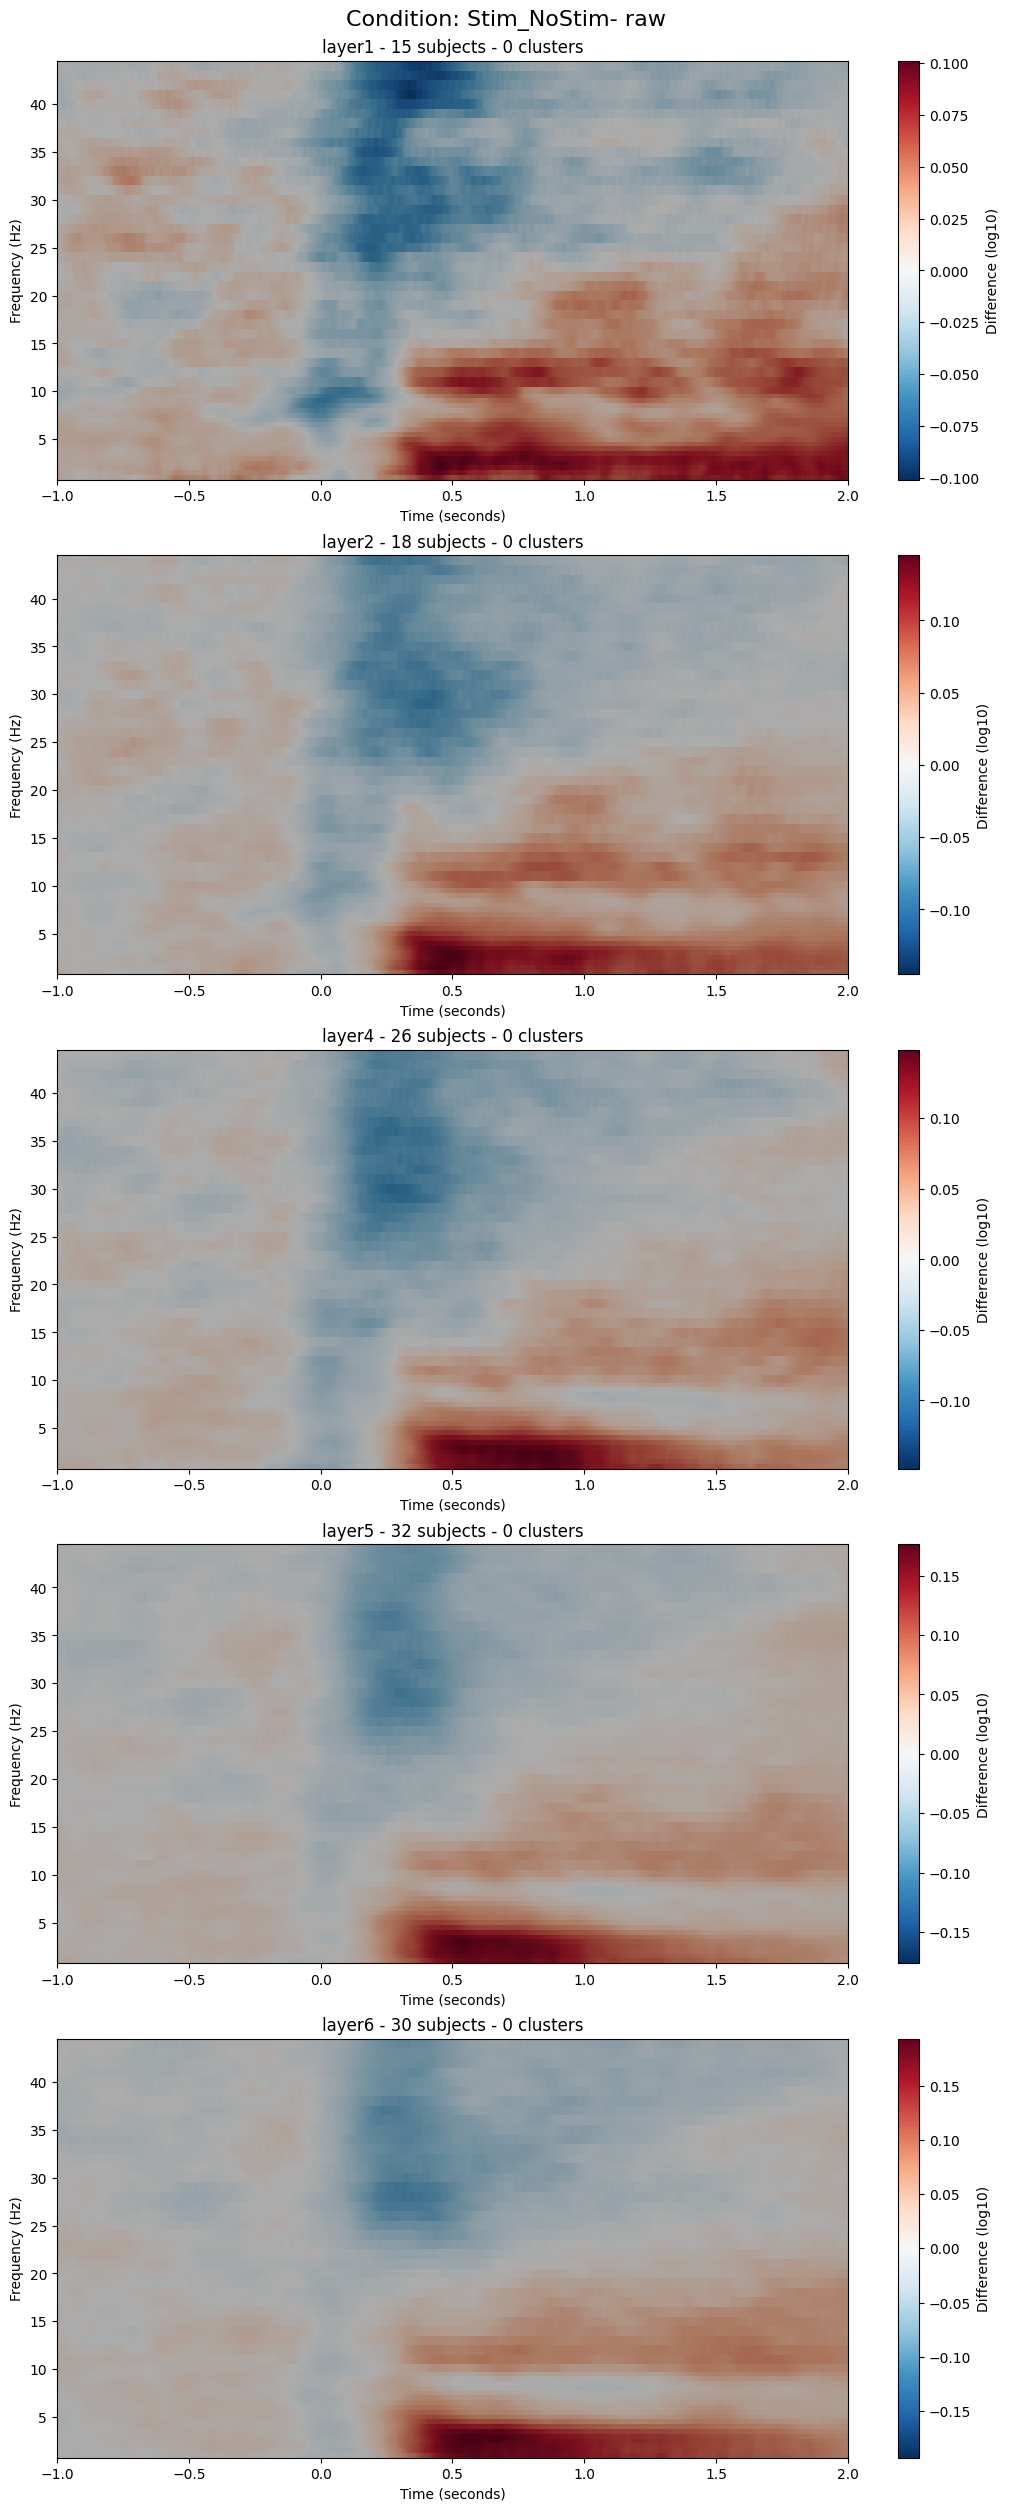

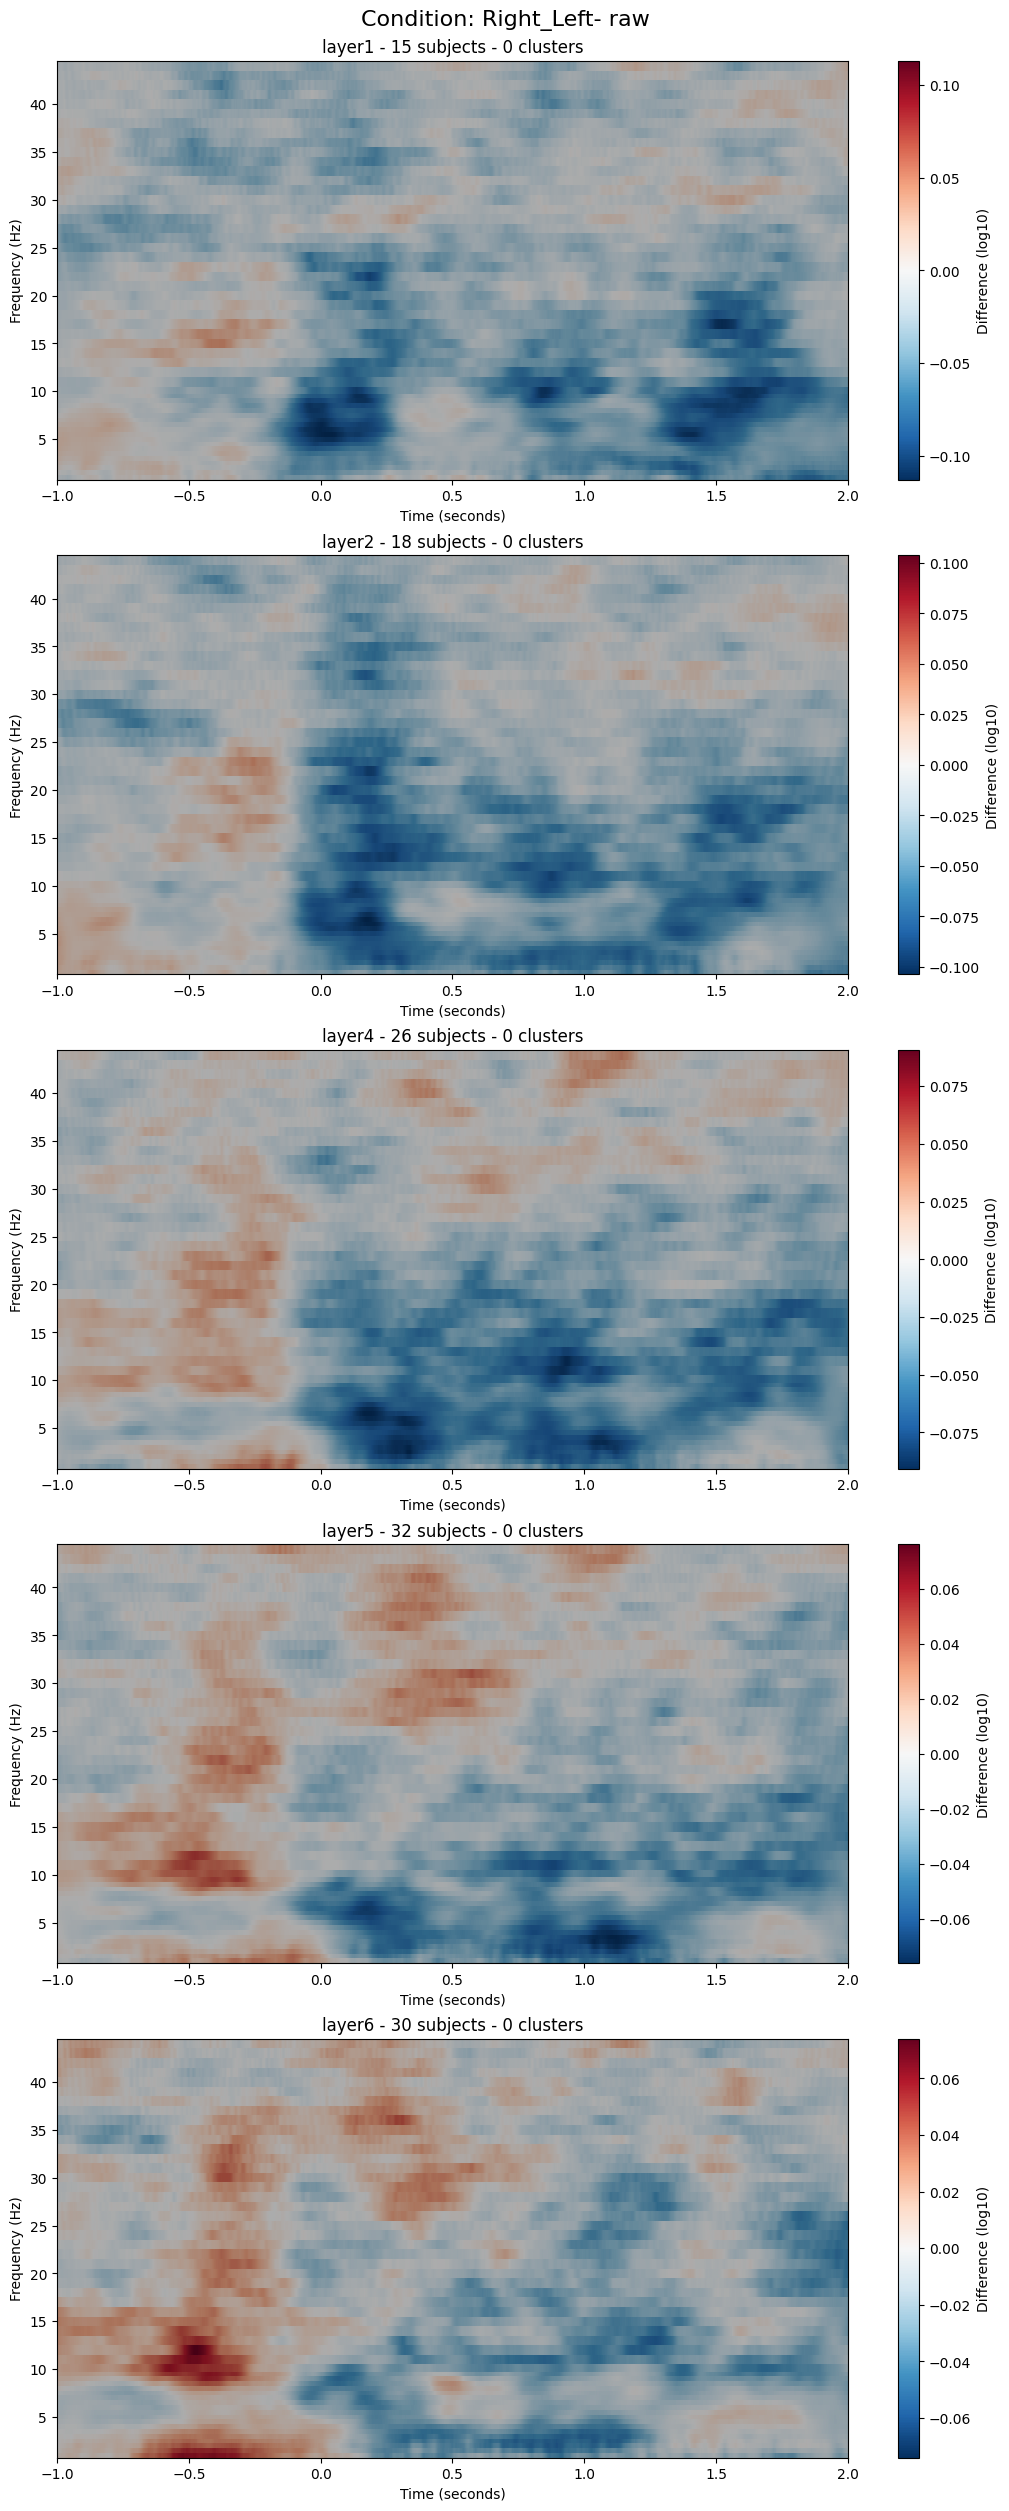

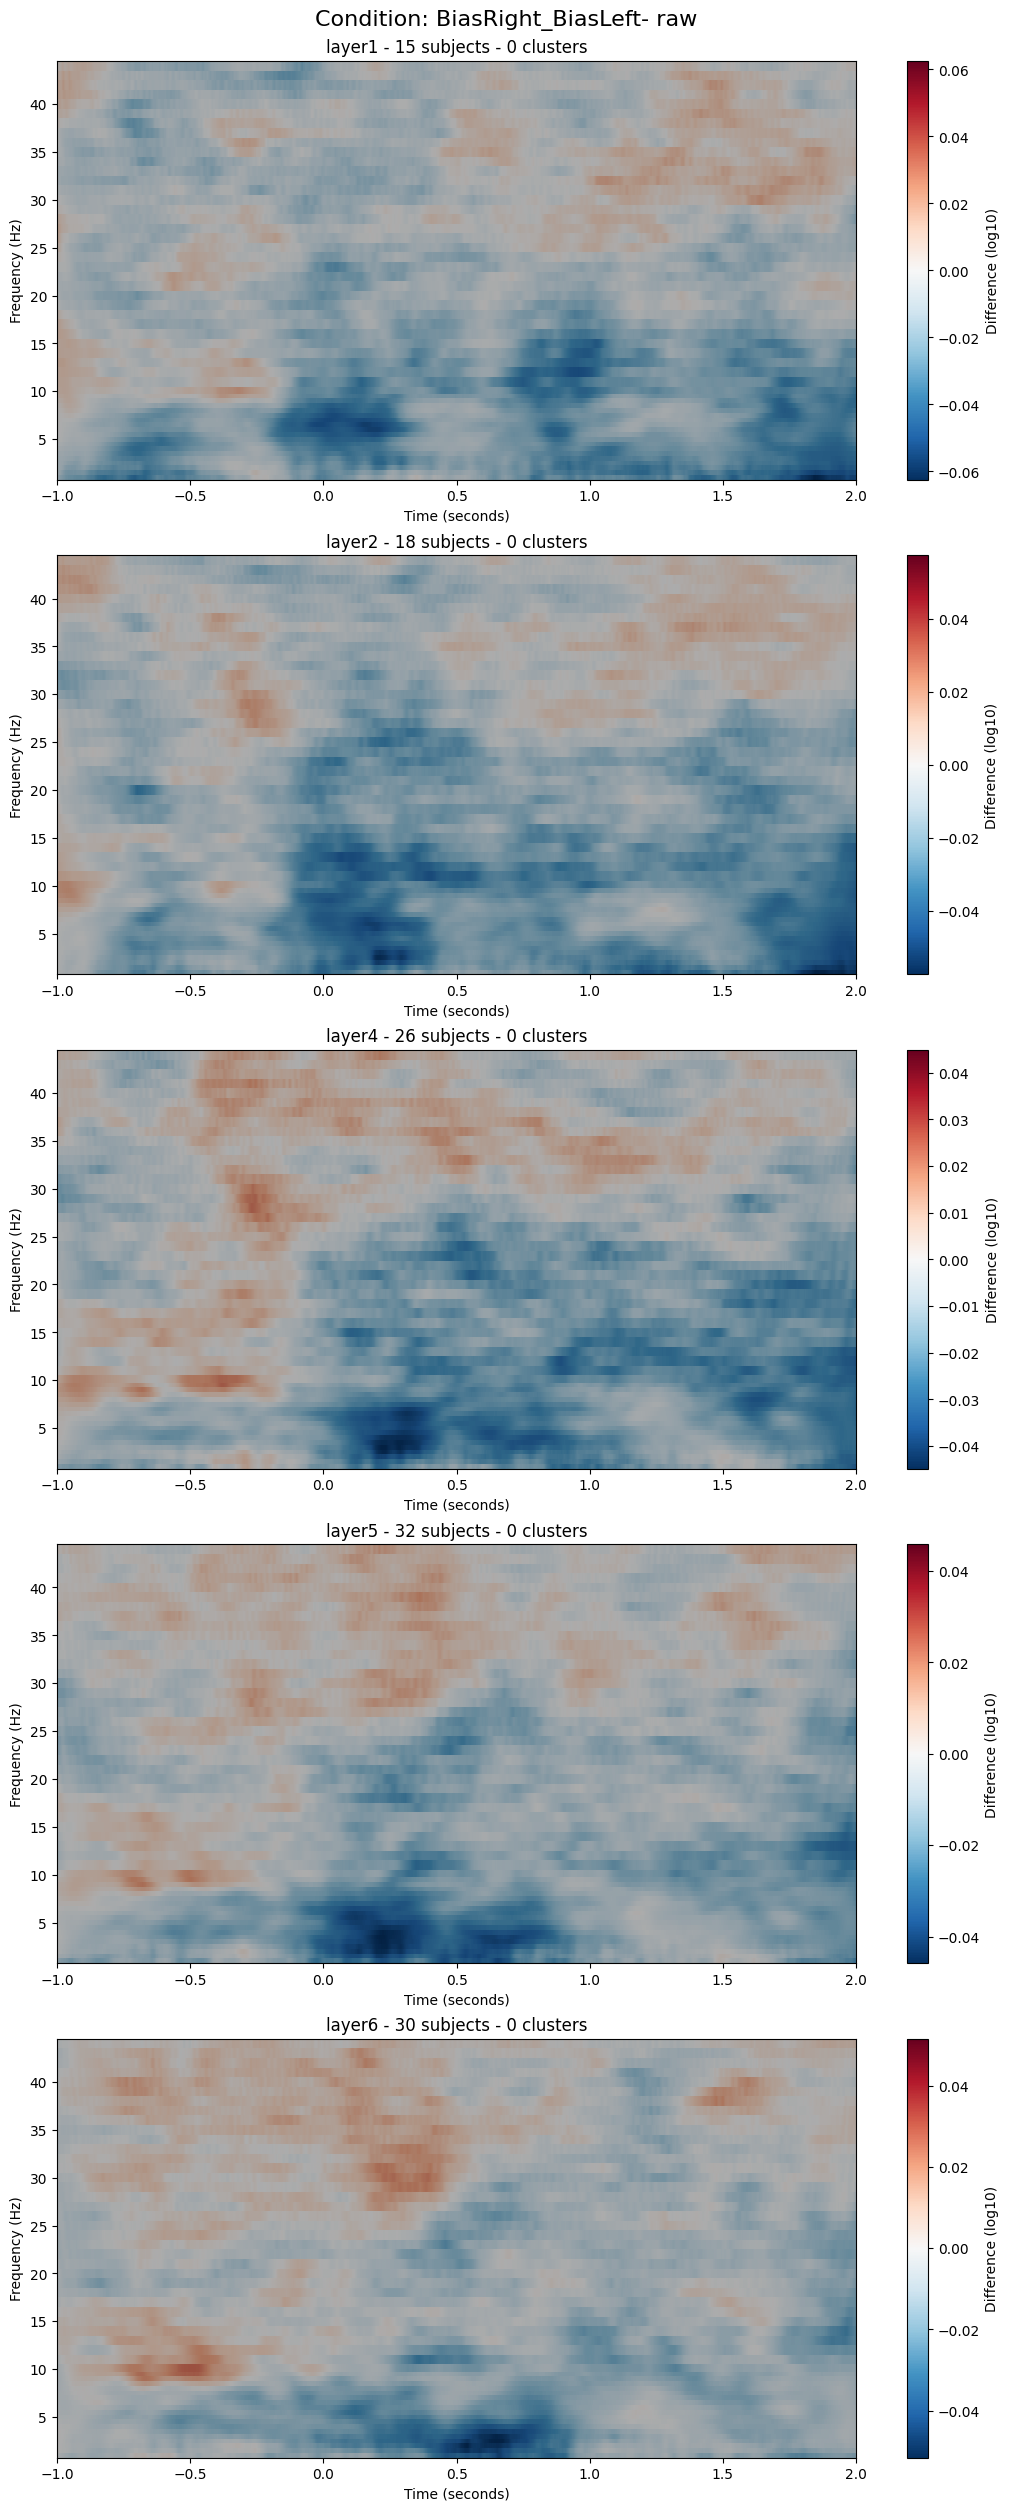

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import mne
import os 

def load_h5_file(file_path):
    """
    Load data from an HDF5 file and print the datasets.

    Parameters:
    file_path (str): The path to the HDF5 file.

    Returns:
    dict: A dictionary containing the datasets.
    """
    data = {}
    with h5py.File(file_path, 'r') as hf:
        for key in hf.keys():
            if hf[key].shape == ():  # Check if the dataset is a scalar
                value = hf[key][()]
                if isinstance(value, bytes):  # Check if the value is a byte string
                    value = value.decode('utf-8')
                data[key] = value
            else:
                data[key] = hf[key][:]
                if isinstance(data[key], np.ndarray) and data[key].dtype.type is np.bytes_:
                    data[key] = data[key].astype(str)
            
    return data


# get time and freq array from a random TFR file that is computed for low frequency band
randomTFRpath = '/mnt/data/AdaptiveControl/IBLrawdata/TF_data/22609d51-0a6a-425d-a3ef-eeb43a9ba350/powerLF_raw_VISp6a_381.h5'
randomTFR = mne.time_frequency.read_tfrs(randomTFRpath)
timearray = randomTFR[0].times
freqarray = randomTFR[0].freqs
# Calculate time and frequency edges
time_edges = np.concatenate(([timearray[0] - (timearray[1] - timearray[0]) / 2],
                                (timearray[:-1] + timearray[1:]) / 2,
                                [timearray[-1] + (timearray[-1] - timearray[-2]) / 2]))
freq_edges = np.concatenate(([freqarray[0] - (freqarray[1] - freqarray[0]) / 2],
                                (freqarray[:-1] + freqarray[1:]) / 2,
                                [freqarray[-1] + (freqarray[-1] - freqarray[-2]) / 2]))



version = 'raw'
for condition in ['Stim_NoStim', 'Right_Left', 'BiasRight_BiasLeft']:
    fig, axs = plt.subplots(5, 1, figsize=(10, 25), constrained_layout=True)
    fig.suptitle(f'Condition: {condition}- {version}', fontsize=16)
    
    for i, layer in enumerate(['layer1', 'layer2', 'layer4', 'layer5', 'layer6']):
        file_path = f'/mnt/data/AdaptiveControl/IBLrawdata/group_level_data/{layer}/TFRpermut_LF_{condition}_{version}_all.h5'
        if not os.path.isfile(file_path):
            
            print(f'File not found: {file_path}')
            continue

        data = load_h5_file(file_path)
        diff_data = data['all_subjects_averageTFR']
        clusters = [data['clusters'][i] for i in range(len(data['clusters']))]
        cluster_p_values = data['cluster_p_values']
        number_of_subject = data['number_of_subject']
        nb_clusters = len(clusters)
        # Create a mask of significant clusters
        significant_mask = np.zeros_like(diff_data, dtype=bool)
        for j, cluster in enumerate(clusters):
            if cluster_p_values[j] < 0.05:
                significant_mask |= cluster.astype(bool)

        # Plot the difference
        ax = axs[i]
        pcm = ax.pcolormesh(time_edges, freq_edges, diff_data, cmap='RdBu_r',
                            vmin=-np.max(np.abs(diff_data)), vmax=np.max(np.abs(diff_data)))
        fig.colorbar(pcm, ax=ax, label='Difference (log10)')
        ax.set_title(f'{layer} - {number_of_subject} subjects - {nb_clusters} clusters')
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Frequency (Hz)')

        # Apply shading to non-significant areas
        non_significant_mask = ~significant_mask
        ax.pcolormesh(time_edges, freq_edges, np.ma.masked_where(non_significant_mask == False, non_significant_mask),
                    cmap='gray', alpha=0.3)

    plt.savefig(f'/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/decoding/figures/{condition}_{version}_groupLevel_all.png')




In [14]:

version = 'csd'
for condition in ['Stim_NoStim', 'Right_Left', 'BiasRight_BiasLeft']:
    fig, axs = plt.subplots(5, 1, figsize=(10, 25), constrained_layout=True)
    fig.suptitle(f'Condition: {condition}- {version}', fontsize=16)
    
    for i, layer in enumerate(['layer1', 'layer2', 'layer4', 'layer5', 'layer6']):
        file_path = f'/mnt/data/AdaptiveControl/IBLrawdata/group_level_data/{layer}/TFRpermut_LF_{condition}_{version}.h5'
        if not os.path.isfile(file_path):
            
            print(f'File not found: {file_path}')
            continue

        data = load_h5_file(file_path)
        diff_data = data['all_subjects_averageTFR']
        clusters = [data['clusters'][i] for i in range(len(data['clusters']))]
        cluster_p_values = data['cluster_p_values']
        number_of_subject = data['number_of_subject']
        nb_clusters = len(clusters)
        # Create a mask of significant clusters
        significant_mask = np.zeros_like(diff_data, dtype=bool)
        for j, cluster in enumerate(clusters):
            if cluster_p_values[j] < 0.05:
                significant_mask |= cluster.astype(bool)

        # Plot the difference
        ax = axs[i]
        pcm = ax.pcolormesh(time_edges, freq_edges, diff_data, cmap='RdBu_r',
                            vmin=-np.max(np.abs(diff_data)), vmax=np.max(np.abs(diff_data)))
        fig.colorbar(pcm, ax=ax, label='Difference (log10)')
        ax.set_title(f'{layer} - {number_of_subject} subjects - {nb_clusters} clusters')
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Frequency (Hz)')

        # Apply shading to non-significant areas
        non_significant_mask = ~significant_mask
        ax.pcolormesh(time_edges, freq_edges, np.ma.masked_where(non_significant_mask == False, non_significant_mask),
                    cmap='gray', alpha=0.3)

    plt.savefig(f'/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/decoding/figures/{condition}_{version}_groupLevel.png')
    plt.close()
